# Projet statistique descriptive 



In [1]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import * 

# chemin vers la donnee 
data_dir = 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive/'
filelist = glob.glob(data_dir + '*.h5')
filelist

['C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03_dask.h5']

In [2]:
from tabata import Opset
#première visualisation brut de la données 

# Première visualisation brut de la données 
La visualisation des graphes nous à permis dans un premier temps de constater des anomalies dans les données et de supprimer ces données pour la suite de nos analyse.En effet ces données dites anormales représentent des mesures ou l'avions n'à pas décollé (sûrement des tests au sols) donc il est légitimes de les supprimer quand on s'intéresse aux comportements de l'avion en vol.

In [3]:
df_opset1=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5')
df_opset2=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5')
df_opset3=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5')

In [4]:
df_opset1.plot()

In [5]:
df_opset2.plot()

In [6]:
df_opset3.plot()

Curiosité: On remarque que fréquament pendant la croisière il y un petit creux très bref de 500 pied, je pense qu'il s'agit d'une allucination du capteur de l'altitude à creuser...

## Creation d'une fonction sur les dataframes pour éliminer les records anormaux
On utilise l'avantage de Dask qui permet de paralléliser sur les dataframes.
Le but de la fonction eliminate_records() est de vérifier la différence entre l'altitude minimum et maximum est d'au plus 15000 ft si c'est le cas alors elle renvoit False et True sinon.



In [7]:
def eliminate_records(df):
    
    alt_min=df['ALT [ft]'].min()
    alt_max=df['ALT [ft]'].max()
    alt_range=alt_max-alt_min
    bol=False
    
    if alt_range<15000:
        bol=True
    return bol
    
    

In [8]:
#on cree notre dataframe avec DASK
ddf1 = lire_hdf_dask(filelist[0], repertoire= data_dir)
#on récupère une liste de booleen où chaque composante fait reférance à une partition 
I = ddf1.map_partitions(lambda df: eliminate_records(df)).compute()
#on sélectione dans un nouveau dataframe les partitions qui ne sont pas anormales 
DDF1=ddf1.partitions[I==False]
# on normalise toute les données excepté les variables booleen 
ddf_norm1 = DDF1.map_partitions(lambda df : normalize(df))

ddf2 = lire_hdf_dask(filelist[2], repertoire= data_dir)
I = ddf2.map_partitions(lambda df: eliminate_records(df)).compute()
DDF2=ddf2.partitions[I==False]
ddf_norm2 = DDF2.map_partitions(lambda df : normalize(df))

ddf3 = lire_hdf_dask(filelist[3], repertoire= data_dir)
I = ddf3.map_partitions(lambda df: eliminate_records(df)).compute()
DDF3=ddf3.partitions[I==False]
ddf_norm3 = DDF3.map_partitions(lambda df : normalize(df))

# Etude sur le vol en entier à l'aide ce corelation et de l'analyse en composante principale

In [9]:
import seaborn as sns


On reprends ce qu'on a vu en TP sur d'autre donnée

In [10]:

# calculate the correlation matrix
df_cor=ddf_norm1.partitions[1].compute()
corr = df_cor.corr()



<Axes: >

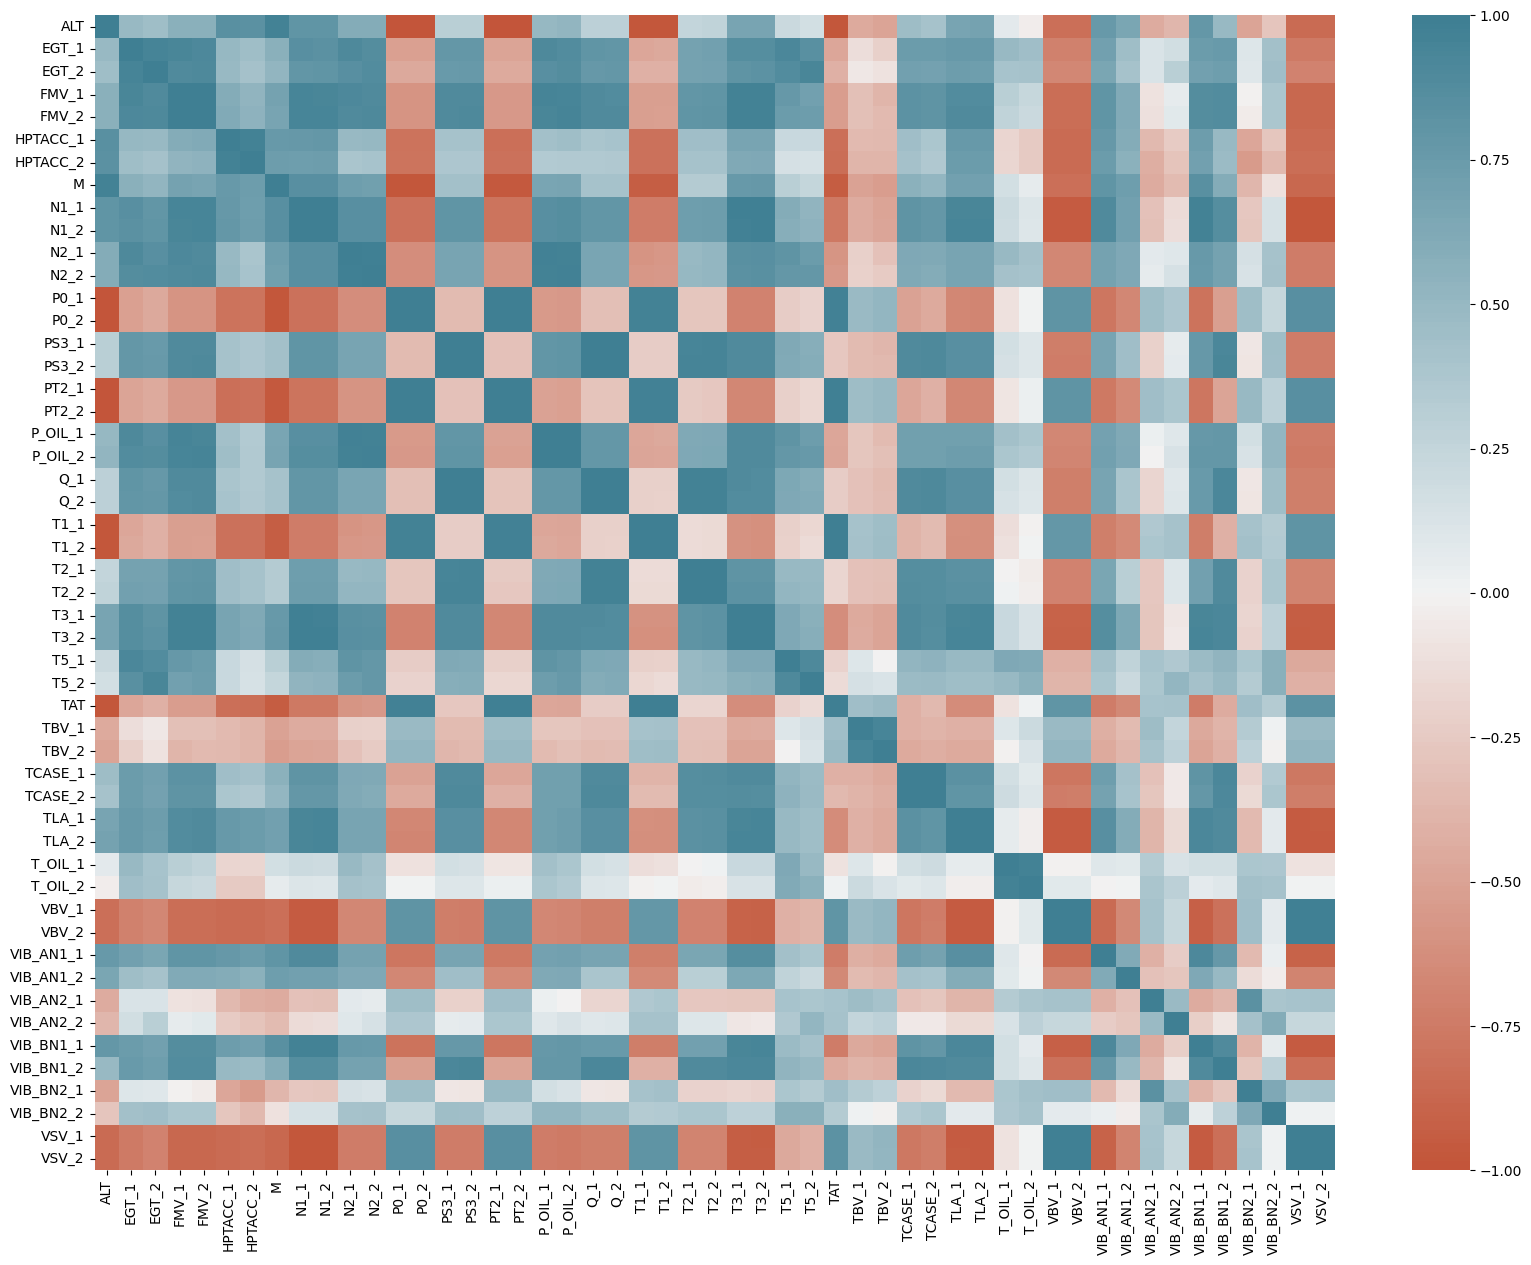

In [11]:
# plot the heatmap
fig = plt.figure(figsize=(20,15))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=False, fmt='.2f', vmin=-1, vmax=1, center=0, 
        cmap=sns.diverging_palette(20, 220, n=200))


In [12]:
df_cor2=ddf_norm1.partitions[2].compute()
corr2 = df_cor2.corr()
COR=corr-corr2

On mesure la difference de correlation entre deux vols ainsi les variables qui sont corrélé entre elle par le vol de la même manière sont nulle. Autrement dit les variables qui apparaisse en coleur sont celle qui on changé de coefficient de correlation entre 2 vols. Quand on reagarde de plus près on vois que les variables lié aux vibration ont celles dont les corrélation change le plus entre les vols.

Ici on fait la différence de correlation entre deux vols qui ce suivent et d'un même avions 

<Axes: >

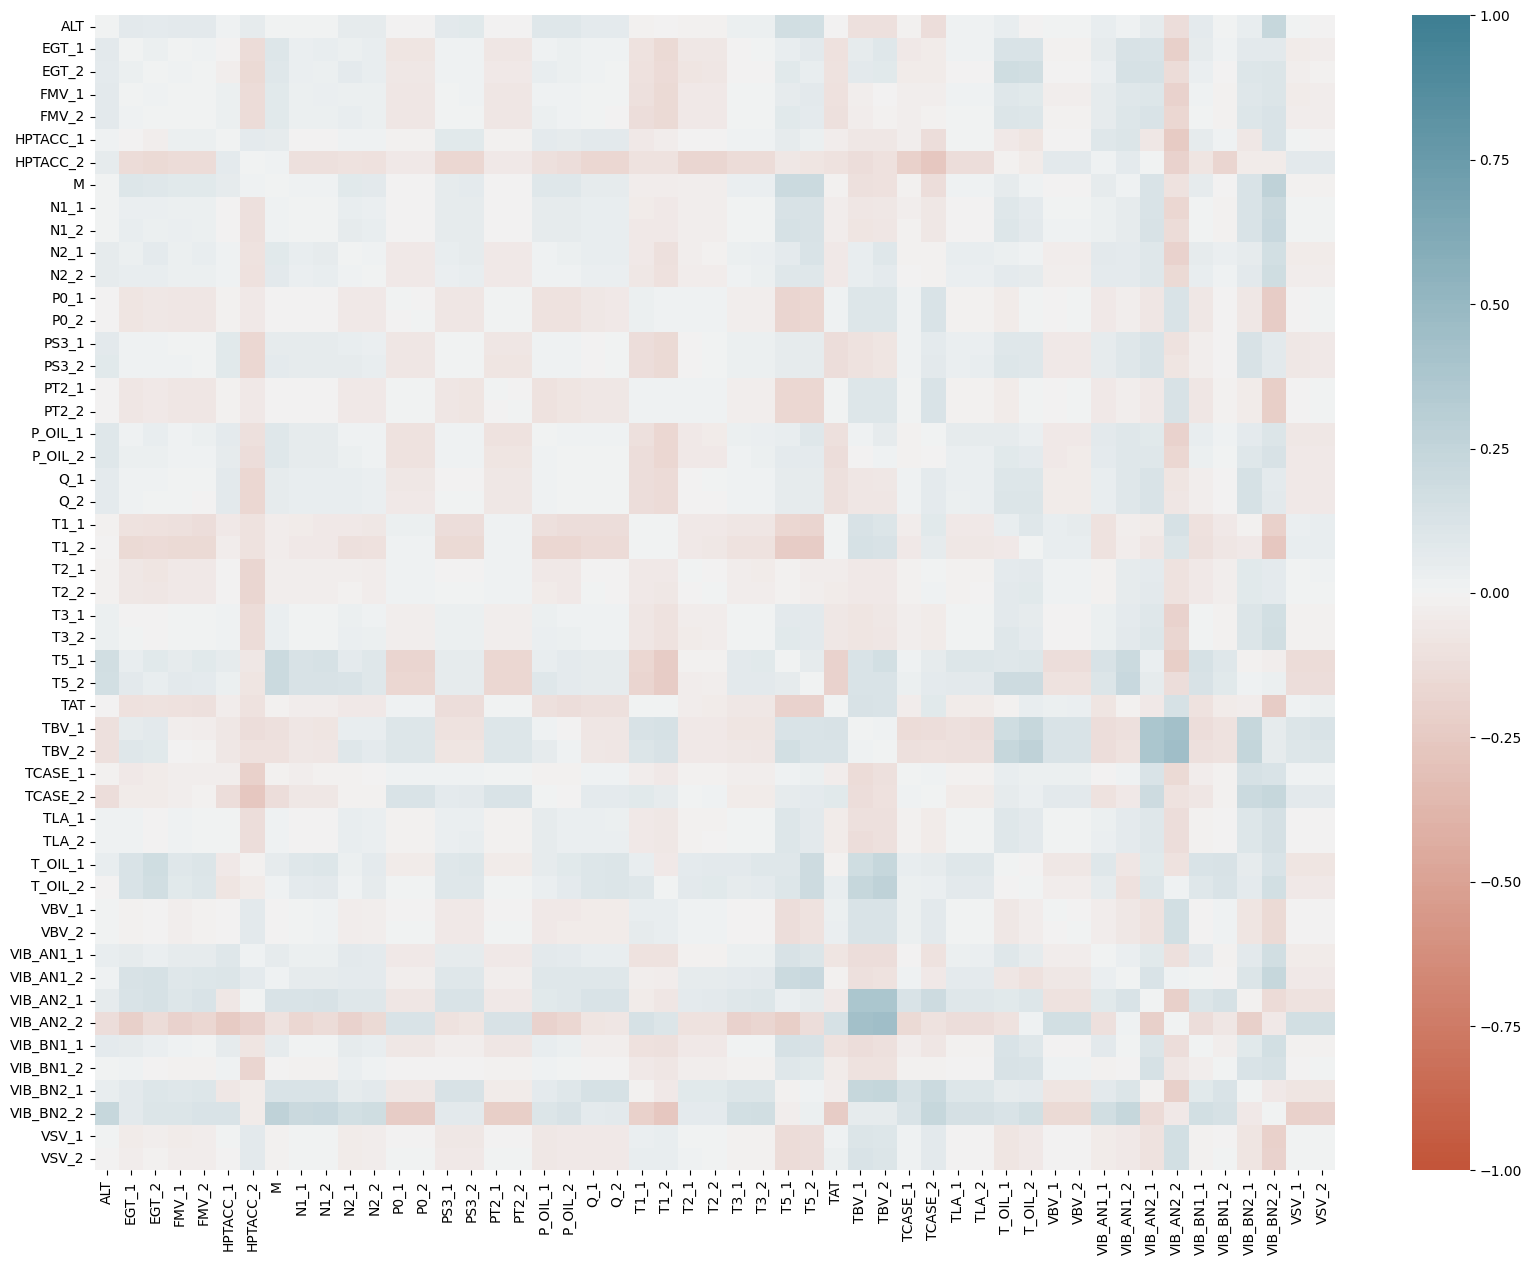

In [13]:
fig = plt.figure(figsize=(20,15))

sns.heatmap(COR, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=False, fmt='.2f', vmin=-1, vmax=1, center=0, 
        cmap=sns.diverging_palette(20, 220, n=200))


In [14]:
from sklearn.decomposition import PCA

In [15]:
from sklearn.preprocessing import StandardScaler

In [46]:
DDF=ddf_norm1.partitions[2].compute()


vol_pca = PCA(n_components=2).fit(DDF)
vol_proj = vol_pca.transform(DDF)

Part de variance expliquée par CP :
[0.59742314 0.18184104]
Pourcentage de variance totale expliquée :
77.9264181537262 %


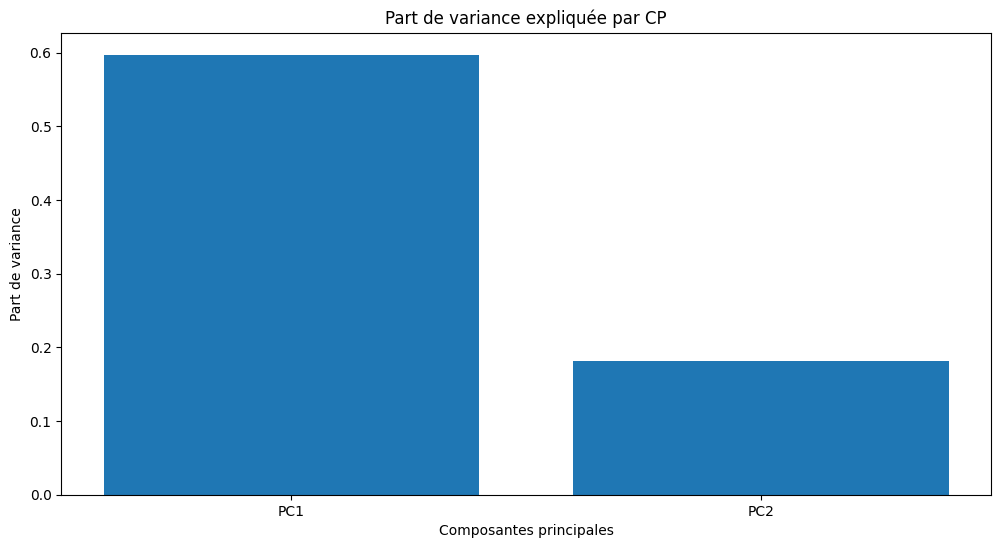

In [47]:
print('Part de variance expliquée par CP :')
print(vol_pca.explained_variance_ratio_)
print('Pourcentage de variance totale expliquée :')
print(vol_pca.explained_variance_ratio_.sum()*100, '%')
# 90% => 7 CP
# 95% => 10 CP
plt.figure(figsize=(12,6))
plt.bar(np.arange(vol_pca.n_components), vol_pca.explained_variance_ratio_, tick_label=['PC'+str(i+1) for i in range(vol_pca.n_components)], log=False)
plt.title('Part de variance expliquée par CP');
plt.ylabel('Part de variance')
plt.xlabel('Composantes principales');

Text(0.5, 1.0, 'Projection PCA du vol')

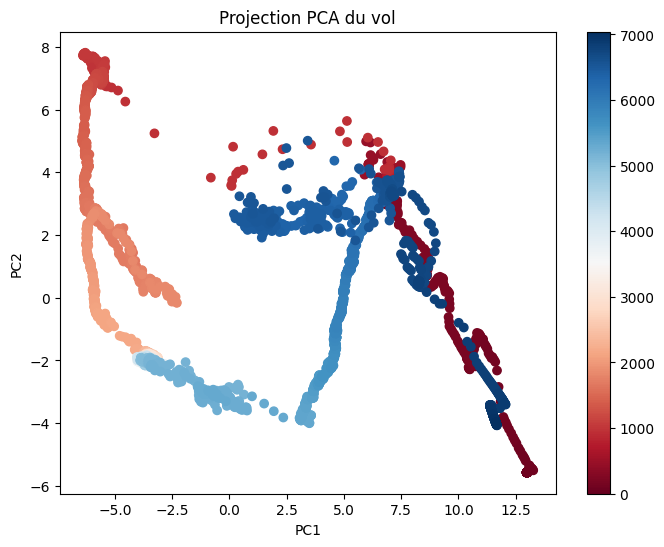

In [48]:
plt.figure(figsize=(8,6))
plt.scatter(vol_proj[:, 0], vol_proj[:, 1], cmap='RdBu', c=np.arange(vol_proj.shape[0]))
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection PCA du vol')

Il va falloir peut être modifier la fonction deriv_glissante lorsque qu'on passera à l'analyse de chaque record 

In [19]:
def deriv_glissante(df):
    
    #on cree une fonction qui prend un data frame qui l'augment de la valeur dy et qui renvoit  un nouveau dataframe contenant que le monté 
    #ATTENTION LA FONCTION PRENDS EN ENTREE DES DONNEES NORMALISEE
    
    dy=np.zeros(len(df))
    
    #on fait une moyenne glissante pour éviter d'être sensible aux bruit. En effet pour le cacul de dérivée le bruit 
    #fausse trés rapidement les données
    y = df['ALT'].rolling(window = 20).mean()
    I = range(y.index[0], y.index[-1],20)
    #calcul de la derivée
    dy[0:len(I)-1] = y[I[1:]].values- y[I[:-1]].values
    #creation d'une nouvelle colonne dans le dataframe vitesse de mont en ft/s
    df['dy']=dy
    #on selectionne le dataframe où les dérivées sont plus grande que 0.01 (la montée)
    df_monte=df[df['dy']>0.01]
    I4=np.zeros(len(df_monte))
    #on verifie qu' avec un shift des données on retombe bien sur les mêmes indices cela permet d'éviter 
    # de prendre en compte des valeurs qui ne serait pas dans la phase de la montée 
    #Attention cette façon de faire est lié aux cas d'un vol d'avion (l'hypothèse admise est que l'avion ne monte qu'une fois)
    #Et s'il existe plus de 6 données anormale consécutives alors elles seront prise en compte 
    
    I4[5:]=df_monte.index[5:]==(df_monte.index+5)[:-5]
    I4[:5]=1
    df_monte2=df_monte[I4==1]

    #je rajoute une nouvelle fois la dérivé cette fois non moyennée pour garder la correspondance entre les variable i.e a un instant t la derivé et les autres mesures sont aussi prise à l'instant t
    vy= np.empty(len(df))
    y2 = df['ALT'].values
    vy[:-1] = y2[1:]-y2[:-1]
    vy[-1]=0
    df['vy']=vy
    
    


    return df_monte2

In [20]:
_VOL=10
DF_monte=ddf_norm1.map_partitions(lambda df:deriv_glissante(df))
DF_monte.partitions[_VOL].compute()

,ALT,EGT_1,EGT_2,FMV_1,FMV_2,HPTACC_1,HPTACC_2,M,N1_1,N1_2,...,VIB_AN1_2,VIB_AN2_1,VIB_AN2_2,VIB_BN1_1,VIB_BN1_2,VIB_BN2_1,VIB_BN2_2,VSV_1,VSV_2,dy
record_101,,,,,,,,,,,,,,,,,,,,,
34,-1.497996,-3.525778,-3.787406,-2.644857,-2.726506,-1.458621,-1.543392,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.052481
35,-1.497996,-3.525778,-3.787406,-2.644857,-2.726506,-1.458621,-1.543392,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.053005
36,-1.497996,-3.525778,-3.787406,-2.644857,-2.726506,-1.460044,-1.543392,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.055372
37,-1.497996,-3.525778,-3.787406,-2.644857,-2.726506,-1.456962,-1.541692,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.054639
38,-1.497996,-3.525778,-3.787406,-2.644857,-2.726506,-1.456962,-1.541692,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.081540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-1.497996,-3.531925,-3.793829,-2.644857,-2.726506,-1.458621,-1.544848,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.027882
92,-1.497996,-3.531925,-3.787406,-2.644857,-2.726506,-1.456962,-1.541692,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.036160
93,-1.497996,-3.531925,-3.793829,-2.644857,-2.726506,-1.456962,-1.543392,-1.851863,-2.289603,-2.311688,...,-1.589433,-1.873868,-0.536182,-1.898331,-1.651577,-1.963053,-1.945944,1.859718,1.863502,0.021788


7278

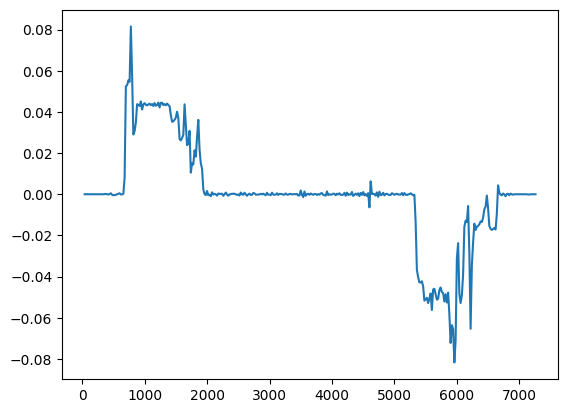

In [21]:
df=ddf_norm1.partitions[10].compute()
y = df['ALT'].rolling(window = 20).mean()
I = range(y.index[0], y.index[-1],20)
dy = y[I[1:]].values- y[I[:-1]].values
plt.plot(I[1:], dy)
len(y)

In [22]:
df12=ddf_norm1.partitions[100].compute()

df_monte2=deriv_glissante(df12)


#plt.plot(df12['EGT_1'][I_monte])


#duree de la monte
duree=len(df_monte2)*20
#Indice monte
I_monte=df_monte2.index*20
#calcul de l'egt max pour chaque moteur pendant la monté
EGT_max_monte1=df12['EGT_1'][I_monte].max()
EGT_max_monte2=df12['EGT_2'][I_monte].max()
EGT_max_monte=max(EGT_max_monte1,EGT_max_monte2)

df_CORR=df12.iloc[I_monte]
#creation de coef corelation
CORR=df_CORR.corr()
corelation_EGT_vy=CORR['vy']['EGT_1']
corelation_EGT_vy

0.5364554499377653

In [23]:



vol_pca2 = PCA(n_components=2).fit(df_CORR)
vol_proj2 = vol_pca2.transform(df_CORR)

Part de variance expliquée par CP :
[0.77452786 0.13392083]
Pourcentage de variance totale expliquée :
90.84486847383877 %


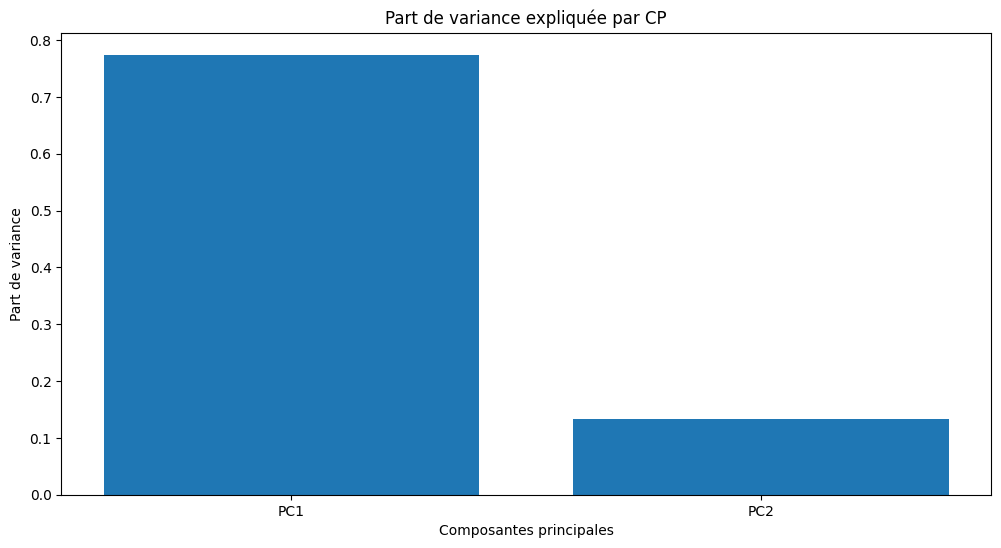

In [24]:
print('Part de variance expliquée par CP :')
print(vol_pca2.explained_variance_ratio_)
print('Pourcentage de variance totale expliquée :')
print(vol_pca2.explained_variance_ratio_.sum()*100, '%')
# 90% => 7 CP
# 95% => 10 CP
plt.figure(figsize=(12,6))
plt.bar(np.arange(vol_pca2.n_components), vol_pca2.explained_variance_ratio_, tick_label=['PC'+str(i+1) for i in range(vol_pca2.n_components)], log=False)
plt.title('Part de variance expliquée par CP');
plt.ylabel('Part de variance')
plt.xlabel('Composantes principales');

Text(0.5, 1.0, 'Projection PCA du vol')

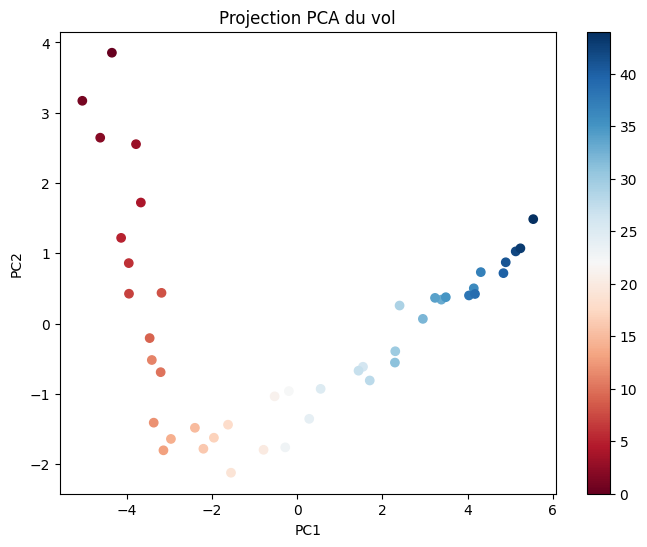

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(vol_proj2[:, 0], vol_proj2[:, 1], cmap='RdBu', c=np.arange(vol_proj2.shape[0]))
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection PCA du vol')

In [26]:
COR_EGT_vy=[]
I=[]
for i in range (0,990,5):
    I.append(i)
    df13=ddf_norm1.partitions[i].compute()
    df_monte3=deriv_glissante(df13)
    I_monte3=df_monte3.index*20
    df_CORR=df13.iloc[I_monte]
    CORR=df_CORR.corr()
    COR_EGT_vy.append(CORR['vy']['EGT_1'])
    

In [27]:
np.median(COR_EGT_vy)

0.7956429511622437

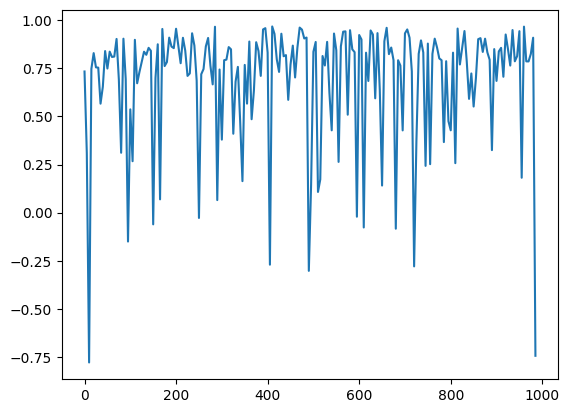

In [28]:
plt.plot(I,COR_EGT_vy)

In [29]:
COR_EGT_vy2=[]
I=[]
for i in range (0,990,5):
    I.append(i)
    df13=ddf_norm2.partitions[i].compute()
    df_monte3=deriv_glissante(df13)
    I_monte3=df_monte3.index*20
    df_CORR=df13.iloc[I_monte]
    CORR=df_CORR.corr()
    COR_EGT_vy2.append(CORR['vy']['EGT_1'])
    

In [30]:
np.median(COR_EGT_vy2)

0.7914873677404468

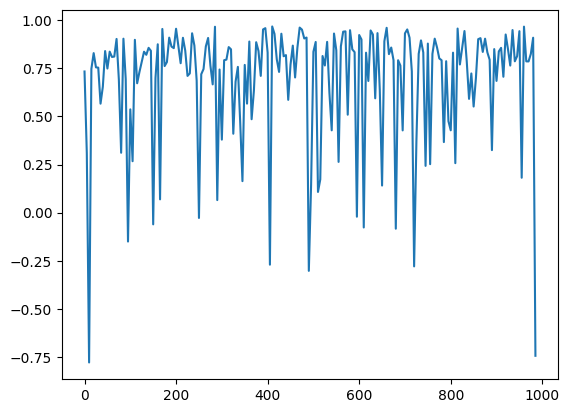

In [31]:
plt.plot(I,COR_EGT_vy)

<Axes: >

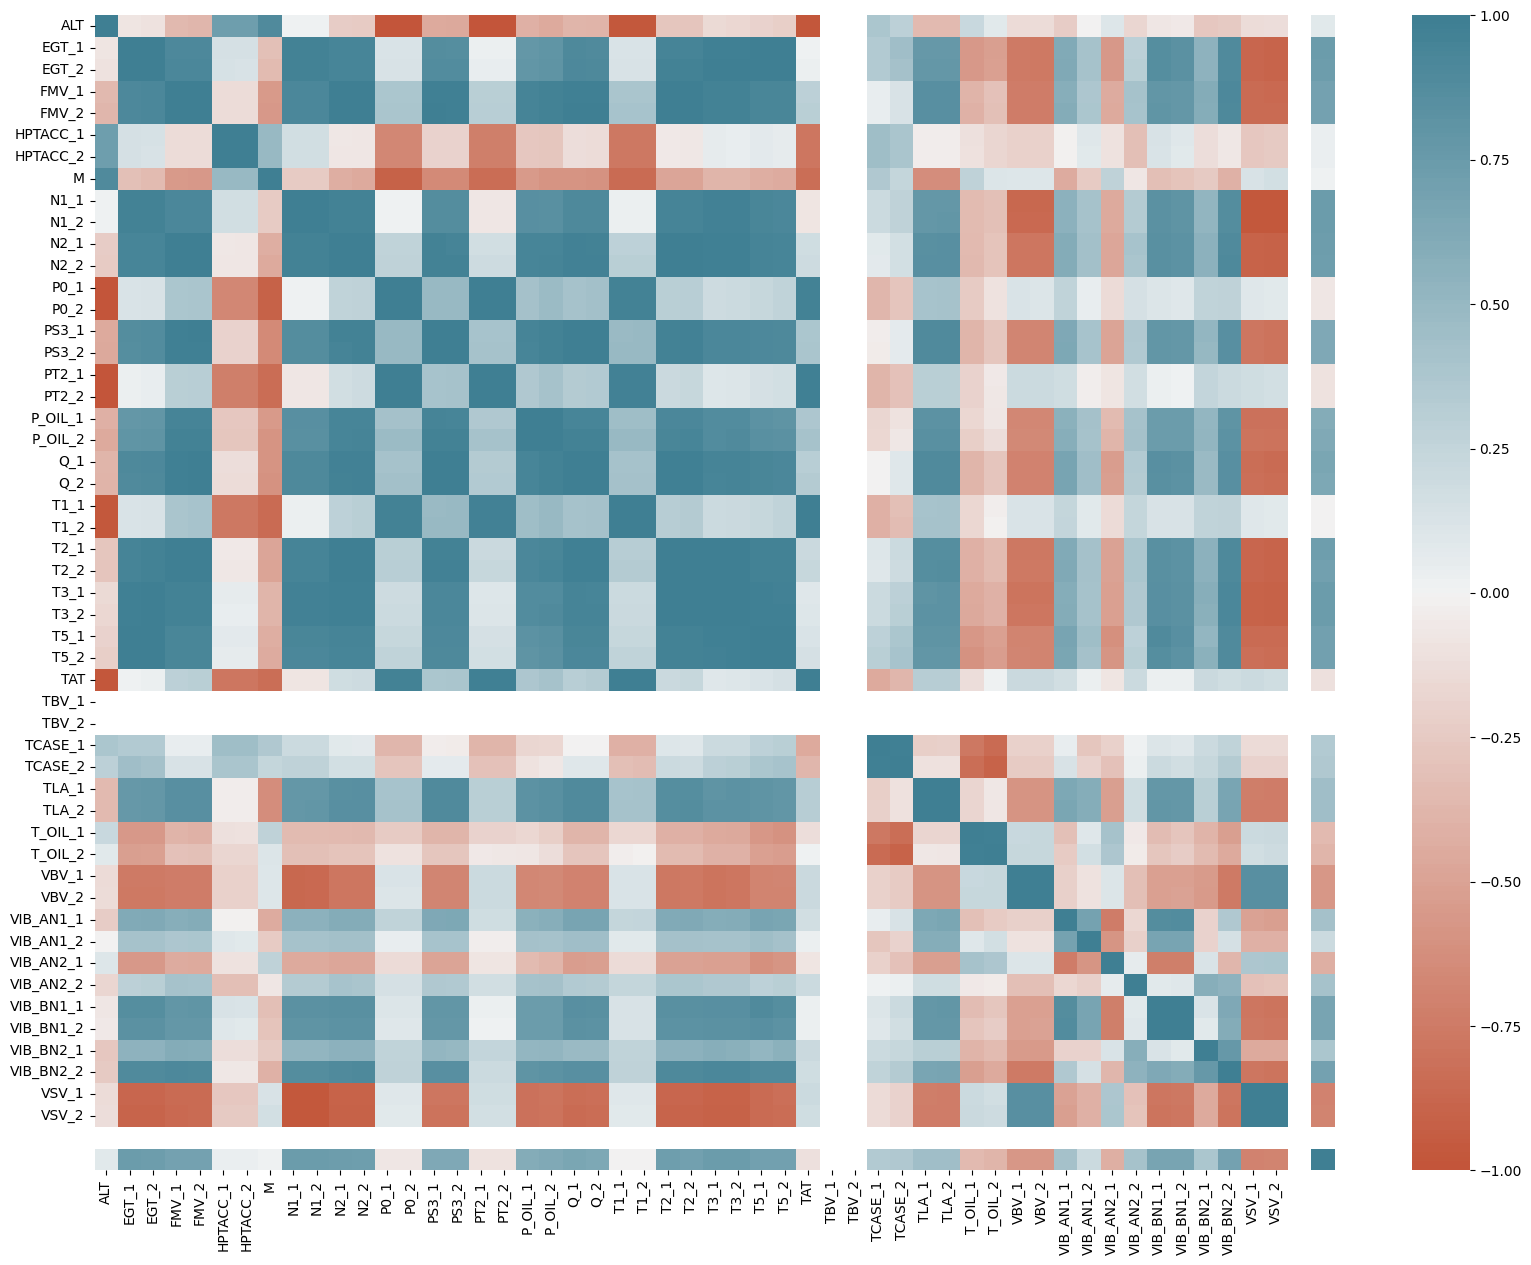

In [32]:
# plot the heatmap
fig = plt.figure(figsize=(20,15))

sns.heatmap(CORR, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=False, fmt='.2f', vmin=-1, vmax=1, center=0, 
        cmap=sns.diverging_palette(20, 220, n=200))


peut paralléliser avec dask 

In [33]:
duree11=[]
EGT_max_monte1=[]
EGT_mean_monte1=[]
Vitesse_max=[]
I=[]
Corelation_dy_EGT=[]
for i in range (0,990):
    I.append(i)
    df11=ddf_norm1.partitions[i].compute()
    #df22=ddf_norm2.partitions[i].compute()
    #df22=ddf_norm3.partitions[i].compute()
    df_monte11=deriv_glissante(df11)
    #[df_monte22]=deriv_glissante(df22)
    #[df_monte33]=deriv_glissante(df33)
    
    duree11.append(len(df_monte11)*20)
    #duree22=len(df_monte22)*20
    #duree33=len(df_monte33)*20

    #Indice monte
    I_monte11=df_monte11.index*20
    #I_monte22=df_monte22.index*20
    #I_monte33=df_monte33.index*20
    #calcul de la vittesse max pendant la monte 
    Vitesse_max.append(df_monte11['dy'].mean())
    #calcul de l'egt max pour chaque moteur pendant la monté
    
    EGT_max_monte11=df11['EGT_1'][I_monte11].max()
    EGT_max_monte21=df11['EGT_2'][I_monte11].max()

    
    #EGT_mean_monte11=df['EGT_1'][I_monte11].mean()
    #EGT_mean_monte21=df['EGT_2'][I_monte11].mean()   
    #EGT_max_monte12=df['EGT_1'][I_monte22].max()
    #EGT_max_monte22=df['EGT_2'][I_monte22].max()
    
    #EGT_max_monte13=df['EGT_1'][I_monte33].max()
    #EGT_max_monte23=df['EGT_2'][I_monte33].max()
    #EGT_mean_monte1.append(EGT_max_monte11)
    EGT_max_monte1.append(max(EGT_max_monte11,EGT_max_monte21))
    #EGT_max_monte2.append(max(EGT_max_monte12,EGT_max_monte22))    
    #EGT_max_monte3.append(max(EGT_max_monte13,EGT_max_monte23))    


# On essaye de retrouver les resulat en TP 
Attention la marge EGT est calculé avec une valeur de réference du moteur, on sait quelle est décroisante. Dans notre cas on calcule l'EGT max et on vérifie si elle est croissante

Text(0.5, 1.0, 'Marge EGT et médiane glissante sur 10 cycles')

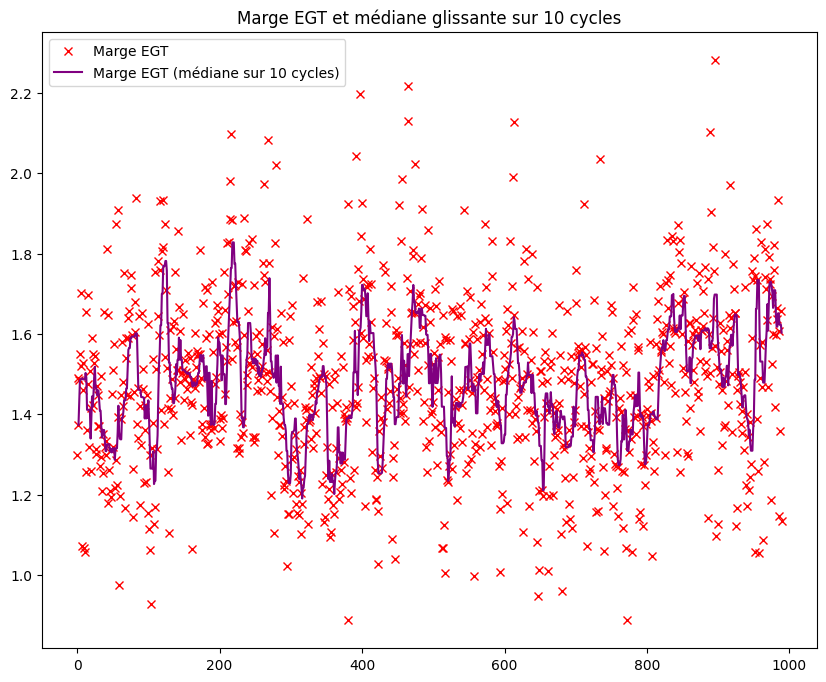

In [34]:
df_analysis =  pd.DataFrame({'EGT':EGT_max_monte1 ,'I':I ,'duree':duree11}).set_index('I')
egtm = df_analysis.rolling(window=10, min_periods=3).median()
plt.figure(figsize=(10,8))
plt.plot(I, EGT_max_monte1, 'rx')
plt.plot(egtm.index, egtm['EGT'], '-', c='purple')
plt.legend(['Marge EGT', 'Marge EGT (médiane sur 10 cycles)'])
plt.title('Marge EGT et médiane glissante sur 10 cycles')

In [35]:
egtm_increasing = egtm.rolling(window=egtm.size, min_periods=1).max().drop_duplicates()

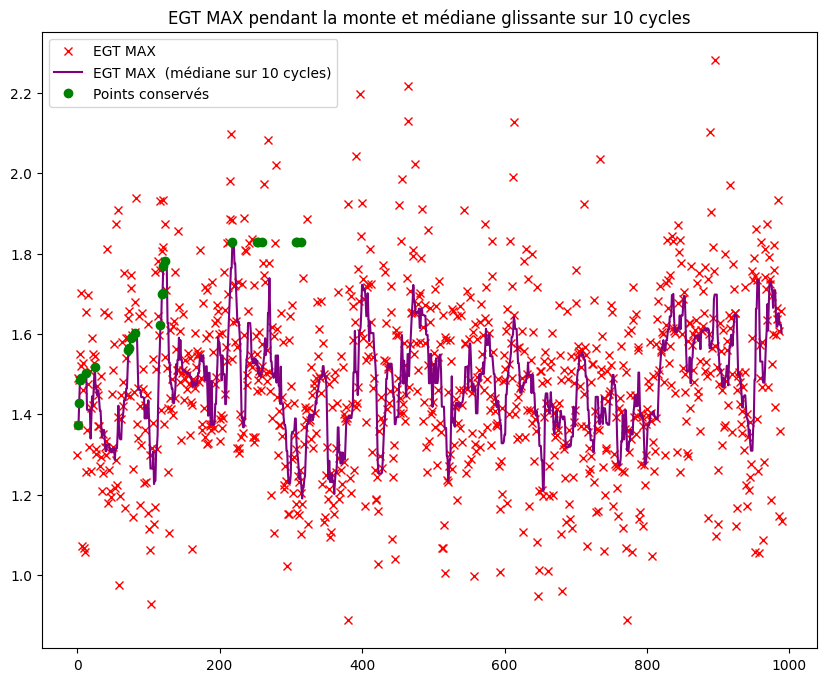

In [36]:
plt.figure(figsize=(10,8))
plt.plot(I, EGT_max_monte1, 'rx')
plt.plot(egtm.index, egtm['EGT'], '-', c='purple')
plt.plot(egtm_increasing.index, egtm_increasing['EGT'], 'o', c='g')
plt.legend(['EGT MAX', 'EGT MAX  (médiane sur 10 cycles)', 'Points conservés'])
plt.title('EGT MAX pendant la monte et médiane glissante sur 10 cycles');


In [37]:
egtm = df_analysis.rolling(window=10, min_periods=3).median()



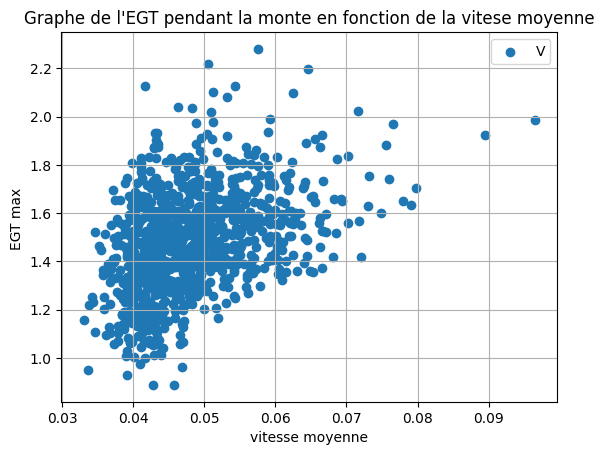

In [38]:
fig, ax = plt.subplots()



plt.scatter(Vitesse_max,EGT_max_monte1)
ax.set_xlabel('vitesse moyenne')
ax.set_ylabel('EGT max ')
plt.title("Graphe de l'EGT pendant la monte en fonction de la vitese moyenne")
ax.legend('Vols')
ax.grid()

In [39]:
reg=pd.DataFrame({'Vitesse_max':Vitesse_max,'EGT_max_monte':EGT_max_monte1})
model=ols(formula="EGT_max_monte~Vitesse_max",data=reg).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          EGT_max_monte   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     196.7
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           6.87e-41
Time:                        08:46:22   Log-Likelihood:                 222.18
No. Observations:                 990   AIC:                            -440.4
Df Residuals:                     988   BIC:                            -430.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9627      0.037     25.703      0.000       0.889       1.036
Vitesse_max    10.7571      0.767     14.025      0.000       9.252      12.262
==============================================================================
Omnibus:                       25.701   Durbin-Watson:                   1.313
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.364
Skew:                           0.374   Prob(JB):                     1.14e-06
Kurtosis:                       3.320   Cond. No.                         125.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
reg

,Vitesse_max,EGT_max_monte
0,0.043666,1.298264
1,0.044126,1.373929
2,0.045305,1.489474
3,0.043187,1.484828
4,0.060666,1.550766
...,...,...
985,0.039815,1.146238
986,0.050206,1.608681
987,0.054122,1.357580
988,0.068300,1.657828


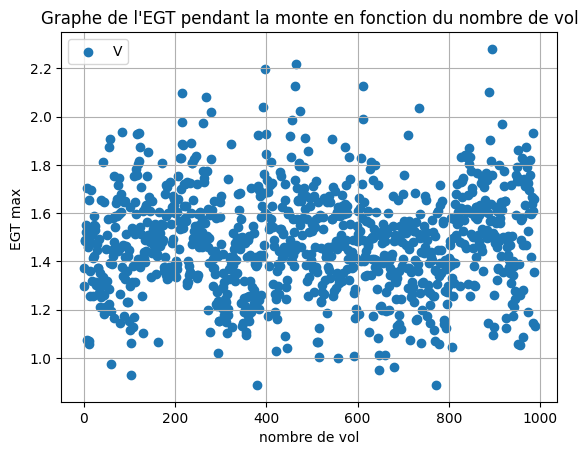

In [41]:

fig, ax = plt.subplots()



plt.scatter(I,EGT_max_monte1)
ax.set_xlabel('nombre de vol')
ax.set_ylabel('EGT max ')
plt.title("Graphe de l'EGT pendant la monte en fonction du nombre de vol")
ax.legend('Vols')
ax.grid()

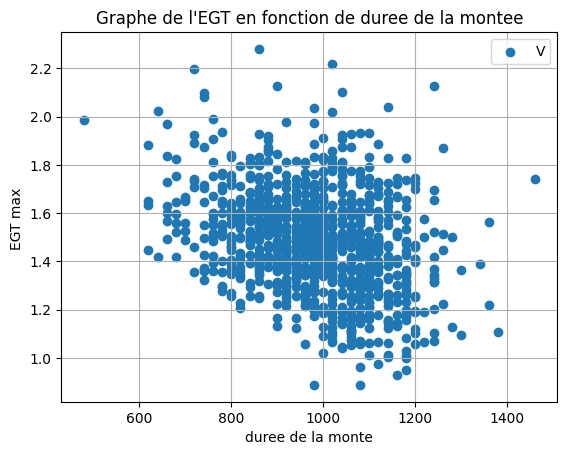

In [42]:

fig, ax = plt.subplots()



plt.scatter(duree11,EGT_max_monte1)
ax.set_xlabel('duree de la monte')
ax.set_ylabel('EGT max ')
plt.title("Graphe de l'EGT en fonction de duree de la montee")
ax.legend('Vols')
ax.grid()

# Suite de l'analyse Corelation et ACP en montee